# Lab 4: Effects of Strain Rate on the Flexural Properties of Tibias

## Goals

- **Hypotheses** - What effects does the experimental variable (strain rate) have on:
  - Flexural Stiffness
  - Flexural Elastic Modulus
  - Ultimate Flexural Strength
  - Modulus of Toughness
- Present the mean $\pm$ standard deviation and perform statistical tests for:
  - Geometric Dimensions: $h_0,~b_0,~h_i,~b_i$
  - Second Moment of Area: $I$
  - Flexural Stiffness: $k_f$
  - Peak Force: $F_{peak}$
  - Flexural Elastic Modulus: $E_f$
  - Ultimate Flexural Stress, $\sigma_{f, ultimate}$
  - Flexural Strain at Failure, $\varepsilon_{f, failure}$
  - Modulus of Toughness, $u_T$

## Data Analysis

- **Preprocessing:** Convert force-deflection data to flexural stress - flexural strain
  - Calculate the **second moment of area**, $I$ using the equation:
$$I_z = \frac{\pi}{64}\left(b_0h_0^3 - b_ih_i^3\right)$$

- Determine the **flexural stiffness**, $k_f$ from the slope of the linear portion of the force-deflection curve

- Calculate **flexural elastic modulus**, $E_f$ from flexural stiffness using the equation below
$$k_f = \frac{48E_fI}{L^3}$$

- Calculate the **ultimate flexural strength** from the **peak force** using the equation below
$$\sigma_x = \frac{Lh_0}{8I}F$$

- Calculate the **flexural strain at failure**, $varepsilon_{f, failure}$ from the deflection at failure using the equation below
$$\varepsilon_x = \frac{6h_0}{L^2}\delta$$

- Determine the **toughness (energy absorbed per unit volume until failure)** by calculating the area underneath the stress-strain curve at failure.
  - Convert force-deflection data to flexural stress - flexural strain and find the area using numerical integration.

In [1]:
# Google Colab: Run this to mount your Google Drive
# from google.colab import drive
# import os
# drive.mount('/content/gdrive', force_remount=True)
# os.chdir('/content/gdrive/MyDrive/BMES 301/Lab 1')

# Set working directory
import os, sys
os.chdir("/home/kabil/sietch/courses/bmes301/lab4")
sys.path.append(os.getcwd())

In [2]:
# Notebook setup

%load_ext autoreload
%autoreload 2

# Import modules
from matplotlib.backends.backend_pdf import PdfPages
from pathlib import Path
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import tools
import re

## Define data path
datapath = Path("data")

In [3]:
def f_test(x,y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1) / np.var(y, ddof=1)
    dfn = x.size - 1
    dfd = y.size - 1
    p = 1 - stats.f.cdf(f, dfn, dfd)
    return p

In [4]:
# Load data
if os.path.exists('results/data.pkl'):
    with open('results/data.pkl', 'rb') as f:
        specimen, data = pickle.load(f)
else:
    import preprocessing
    specimen, data = preprocessing.main()

## Fixed Span Length
L = 40  # mm

**Note:** For now, only using A and B because segmentation on C and D is not
consistent.

#### Specimen Dimensions

In [5]:
# Get the dimensions of the specimens
dims = specimen.drop(columns=['team'])

# Compute a summary statistics table for each strain_rate
# and use a t-test to compare the mean of each strain_group
for strain in dims['strain_rate'].unique():
    # Define strain groups
    if strain == 0.0016:  x, y = 'A', 'C'
    elif strain == 0.40:  x, y = 'B', 'D'

    # Subset data
    _d = (dims[dims['strain_rate'] == strain]
        .drop(columns=['strain_rate']))

    # Compute means
    mean = (_d.groupby('strain_group')
        .mean()
        .to_dict(orient='index'))  # type: ignore

    # Compute standard deviations
    stdv = (_d.groupby('strain_group')
        .std()
        .to_dict(orient='index'))  # type: ignore

    # Compute t-test
    ttest = stats.ttest_ind(
        _d[_d['strain_group'] == x].drop(columns=['strain_group']),
        _d[_d['strain_group'] == y].drop(columns=['strain_group']),
        equal_var=True
    ).pvalue

    # Create a summary table
    res = {x: {}, y: {}}
    for group in [x, y]:
        res[group] ={
            "h0 (mm)": f"{mean[group]['h0']:.2f} ± {stdv[group]['h0']:.2f}",
            "b0 (mm)": f"{mean[group]['b0']:.2f} ± {stdv[group]['b0']:.2f}",
            "hi (mm)": f"{mean[group]['hi']:.2f} ± {stdv[group]['hi']:.2f}",
            "bi (mm)": f"{mean[group]['bi']:.2f} ± {stdv[group]['bi']:.2f}",
            "I (mm^4)": f"{mean[group]['I']:.2f} ± {stdv[group]['I']:.2f}"
        }
    res = pd.DataFrame(res).T

    # Add row with p-values
    res.loc['p-value'] = ttest.round(4)

    display(res)

,h0 (mm),b0 (mm),hi (mm),bi (mm),I (mm^4)
A,7.95 ± 0.96,9.29 ± 1.49,5.17 ± 1.33,6.33 ± 1.74,190.43 ± 87.65
C,7.56 ± 0.79,8.67 ± 0.92,4.61 ± 0.94,5.40 ± 1.02,162.43 ± 62.26
p-value,0.3299,0.276,0.2902,0.1608,0.4209


,h0 (mm),b0 (mm),hi (mm),bi (mm),I (mm^4)
B,8.39 ± 1.00,9.62 ± 1.46,5.58 ± 1.37,6.21 ± 1.46,230.36 ± 103.74
D,7.84 ± 1.41,9.31 ± 1.93,5.39 ± 1.53,6.31 ± 2.29,186.50 ± 121.99
p-value,0.3244,0.6854,0.7747,0.9054,0.3978


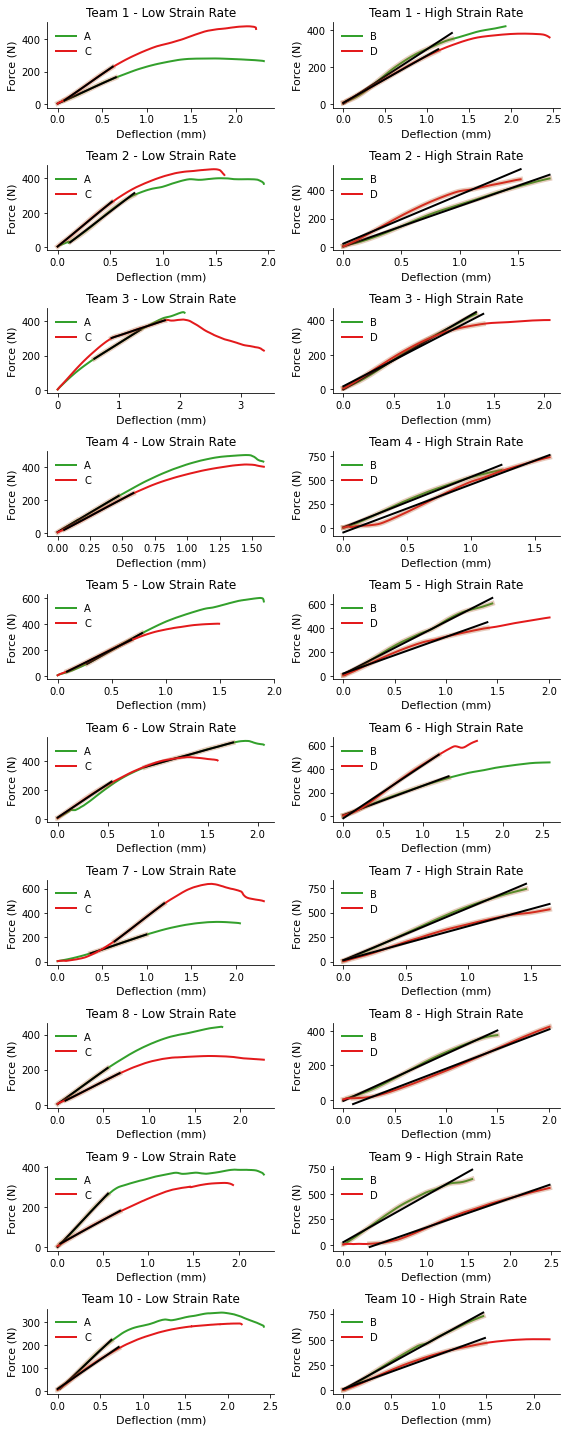

In [11]:
# Fit the linear region of the force-deflection curve
# Slope = Flexural Stiffness

# Create figure
fig, axes = plt.subplots(10, 2, figsize=(8, 20))
# colors = sns.color_palette("Paired").as_hex()[2:6]
colors = ['#33a02c', '#33a02c', '#e31a1c', '#e31a1c']
res = []

for team, axis in zip(data['team'].unique(), axes):
    for sample, color in zip(data['strain_group'].unique(), colors):
        # Pick axis
        if sample in ['A', 'C']:  
            ax = axis[0]
            ax.set_title(f"Team {team} - Low Strain Rate")
        else:  
            ax = axis[1]
            ax.set_title(f"Team {team} - High Strain Rate")

        # Subset the data
        df = (data
            .query("strain_group == @sample and team == @team")
            .reset_index(drop=True))

        # Define variables for the linear regression
        X, Y = df['deflect'].values, df['force'].values

        # Identify the linear region of the data
        r2_max = 0
        step = 50
        region_length = 1000 if sample in ['A', 'C'] else 200
        for i in range(len(X), 0, -step):
            for j in range(0, i, step):
                # Skip if the subarray is too short
                if abs(i - j) < region_length:  continue

                # Compute R^2 for this region
                r2 = stats.linregress(X[j:i], Y[j:i]).rvalue**2  # type: ignore

                # Update the selected region if the R^2 is higher
                if r2 > r2_max:
                    r2_max = r2
                    region = slice(j, i)

        # Create index for specimen table
        J = (specimen['team'] == team) & (specimen['strain_group'] == sample)

        # # Flexural Stiffness  [Fit a regression model]
        kf, intercept, r, p, _ = stats.linregress(X[region], Y[region])  # type: ignore

        # # Flexural Elastic Modulus
        E = kf * L**3 / (48 * specimen[J]['I'])

        # # Peak Force and UFS
        I = np.argmax(Y)  # type: ignore
        F_peak, UFS = Y[I], df['flex_stress'][I]

        # Flexural strain at failure
        FSF = df['flex_stress'].values[-1]

        # Toughness  [Compute the area under the curve]
        strain = df['flex_strain'].values
        stress = df['flex_stress'].values
        toughness = np.trapz(stress, strain)  # type: ignore

        # Store results
        _res = pd.DataFrame({
            'team': team, 'strain_group': sample,
            'kf': kf, 'E': E, 'F_peak': F_peak,
            'UFS': UFS, 'FSF': FSF, 'T': toughness,
        })
        res.append(_res)

        # Plot the data
        sns.lineplot(x=X, y=Y, ax=ax, color=color,
                     label=f"{sample}", linewidth=2)
        sns.lineplot(x=X[region], y=Y[region], ax=ax, color="#b15928",
                     alpha=0.3, linewidth=5)
        sns.lineplot(x=X[region], y=kf * X[region] + intercept, ax=ax,
                        color="black", linewidth=2)
        # Remvoe spines
        sns.despine(ax=ax)
        # Legend frameon
        ax.legend(frameon=False, loc='upper left')
        # Set axis labels
        ax.set_xlabel("Deflection (mm)", fontsize=11)
        ax.set_ylabel("Force (N)", fontsize=11)

plt.tight_layout()

In [7]:
# Concatenate results
results = pd.concat(res)

# Assign strain rate
results['strain_rate'] = results['strain_group'].map({
    'A': 0.0016, 'B': 0.40, 'C': 0.0016, 'D': 0.40
})
results.drop(columns=['team', 'strain_group'], inplace=True)

results.head()

,kf,E,F_peak,UFS,FSF,T,strain_rate
0,246.937206,3782.858572,280.777740,108.069296,101.746075,4.640134,0.0016
1,295.143718,2592.415780,419.289490,104.547159,104.547159,3.518349,0.4000
2,380.506463,2034.803828,477.548737,78.815078,76.087265,3.570438,0.0016
3,255.667057,3810.513204,379.363007,137.818748,130.487350,5.705654,0.4000
4,469.915059,4783.882439,401.265106,108.763243,99.900729,4.118647,0.0016


In [8]:
# Run some f-tests
f_pvals = []
for var in results.columns[:-1]:
    x = results.loc[results['strain_rate'] == 0.0016, var]
    y = results.loc[results['strain_rate'] == 0.40, var]
    p = round(f_test(x, y), 4)

    print(f"{var}: {p:.4f}")
    f_pvals.append(p)

kf: 0.1939
E: 0.6843
F_peak: 0.7991
UFS: 0.9970
FSF: 0.9948
T: 0.9960


In [9]:
# Compute a summary statistics table for each strain_rate
# and use a t-test to compare the mean of each strain_group

## Compute means
mean = (results.groupby('strain_rate')
    .mean()
    .to_dict(orient='index'))  # type: ignore

## Compute standard deviations
stdv = (results.groupby('strain_rate')
    .std()
    .to_dict(orient='index'))  # type: ignore

## Run t-tests

## Ha: mean(low strain) < mean(high strain)
vars = ['kf', 'E', 'F_peak', 'UFS', 'FSF']
ttest1 = stats.ttest_ind(
    results.loc[results['strain_rate'] == 0.0016, vars],
    results.loc[results['strain_rate'] == 0.40, vars],
    equal_var=True,
    alternative='less'
).pvalue

## Ha: mean(low strain) > mean(high strain)
vars = ['T']
ttest2 = stats.ttest_ind(
    results.loc[results['strain_rate'] == 0.0016, vars],
    results.loc[results['strain_rate'] == 0.40, vars],
    equal_var=True,
    alternative='greater'
).pvalue

## Combine p-values
ttest = np.concatenate([ttest1, ttest2])

# Create a summary table
res = {"0.0016": {}, "0.40": {}}
for group in [0.0016, 0.40]:
    g = "0.0016" if group == 0.0016 else "0.40"

    res[g] ={
        "kf (MPa)": f"{mean[group]['kf']:.2f} ± {stdv[group]['kf']:.2f}",
        "E (MPa)": f"{mean[group]['E']:.2f} ± {stdv[group]['E']:.2f}",
        "F_peak (N)": f"{mean[group]['F_peak']:.2f} ± {stdv[group]['F_peak']:.2f}",
        "UFS (MPa)": f"{mean[group]['UFS']:.2f} ± {stdv[group]['UFS']:.2f}",
        "FSF": f"{mean[group]['FSF']:.2f} ± {stdv[group]['FSF']:.2f}",
        "T (MPa)": f"{mean[group]['T']:.2f} ± {stdv[group]['T']:.2f}"
    }
res = pd.DataFrame(res).T

# Add row with p-values
res.loc['p-value (F-Test)'] = f_pvals
res.loc['p-value (t-Test)'] = ttest.round(4)

display(res)

,kf (MPa),E (MPa),F_peak (N),UFS (MPa),FSF,T (MPa)
0.0016,357.41 ± 124.34,2992.86 ± 1153.41,418.45 ± 98.88,99.54 ± 22.11,91.65 ± 23.14,3.92 ± 1.02
0.40,363.64 ± 101.66,2840.70 ± 1289.60,532.56 ± 120.23,122.71 ± 42.80,122.33 ± 42.68,3.83 ± 1.92
p-value (F-Test),0.1939,0.6843,0.7991,0.997,0.9948,0.996
p-value (t-Test),0.4316,0.6519,0.0011,0.0189,0.0037,0.4251
